In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

In [2]:
# Define a custom directionality metric
def directionality_score(y_true, y_pred):
    """Calculate the percentage of times the model correctly predicts the direction of change."""
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    correct_direction = direction_true == direction_pred
    return np.mean(correct_direction) * 100 


In [3]:
data = pd.read_csv('Lagged VIX Data.csv',index_col="Date")
data.index = pd.to_datetime(data.index)
data_clean = data
data_clean.fillna(data_clean.mean(), inplace=True)

In [4]:
data_clean

,Unemployment Rate,CPI,Three Month T Bill Rate,Six Month T Bill Rate,10-Year Treasury Constant Maturity Rate,Fed Rate,BBB Rate,SP500 Index,GDP,Initial Claims,...,OIL Volume,VIX,Next Month VIX,DJI High Minus Low,NASDAQ High Minus Low,GOLD High Minus Low,OIL High Minus Low,FTSE High Minus Low,NIKKEI High Minus Low,RUSSELL2000 High Minus Low
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,5.7,237.430,0.02,0.05,2.30,0.09,3.50,2006.350,17912.079,1155000,...,22051206,16.530,13.330,1540.418945,524.909668,8.839996,38.559998,550.099609,2004.879883,133.859985
2014-11-01,5.8,236.983,0.02,0.07,2.33,0.09,3.63,2039.820,17912.079,1458000,...,26087667,13.330,15.155,616.470703,215.939941,6.290001,42.080002,328.200195,807.169922,39.780029
2014-12-01,5.6,236.252,0.03,0.11,2.21,0.12,3.78,2063.890,17912.079,1138000,...,60335993,15.155,19.455,1035.859375,267.640137,6.579994,52.399994,608.500000,1357.890625,86.929932
2015-01-01,5.7,234.747,0.03,0.08,1.88,0.11,3.64,2024.465,18063.529,1438000,...,83013319,19.455,15.450,815.478516,213.899902,13.260002,32.400009,566.799805,1258.019531,61.500000
2015-02-01,5.5,235.342,0.02,0.07,1.98,0.11,3.65,2096.990,18063.529,1205000,...,93894742,15.450,15.065,1206.621094,408.790039,8.870003,21.680008,235.200195,1593.521484,85.880005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,3.9,313.207,5.24,5.15,4.54,5.33,5.84,5108.065,29016.714,841000,...,107181600,15.745,12.920,2203.441406,1267.870117,18.800003,5.840004,406.100098,3964.160156,194.520020
2024-05-01,4.0,313.225,5.25,5.17,4.48,5.33,5.75,5256.815,29016.714,892000,...,63365200,12.920,12.645,2296.859375,1475.020508,14.949997,4.500000,363.000488,1820.160156,144.290039
2024-06-01,4.1,313.049,5.24,5.15,4.31,5.33,5.63,5433.740,29016.714,1184000,...,41372900,12.645,13.190,1324.011719,1388.570312,8.430008,9.599998,258.800293,1838.429688,95.300049


In [5]:
# Create lagged features
# Define the columns you want to add lags for
columns_to_lag = ['VIX', 'Unemployment Rate', 'CPI', 'Three Month T Bill Rate', 'SP500 Index']

# Define the number of lags you want to create (e.g., 1-month and 2-month lags)
num_lags = [1, 2]

# Create lagged features
for col in columns_to_lag:
    for lag in num_lags:
        data_clean[f'{col} lagged {lag}'] = data_clean[col].shift(lag)

# Drop rows with NaN values introduced by shifting
data_clean.dropna(inplace=True)

# Add a column for the month to allow seasonal patterns to be captured
data_clean['Month'] = data_clean.index.month

# Now, vix_data contains the original columns plus the new lagged features
data_clean.head()



,Unemployment Rate,CPI,Three Month T Bill Rate,Six Month T Bill Rate,10-Year Treasury Constant Maturity Rate,Fed Rate,BBB Rate,SP500 Index,GDP,Initial Claims,...,VIX lagged 2,Unemployment Rate lagged 1,Unemployment Rate lagged 2,CPI lagged 1,CPI lagged 2,Three Month T Bill Rate lagged 1,Three Month T Bill Rate lagged 2,SP500 Index lagged 1,SP500 Index lagged 2,Month
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01,5.6,236.252,0.03,0.11,2.21,0.12,3.78,2063.890,17912.079,1138000,...,16.530,5.8,5.7,236.983,237.430,0.02,0.02,2039.820,2006.350,12
2015-01-01,5.7,234.747,0.03,0.08,1.88,0.11,3.64,2024.465,18063.529,1438000,...,13.330,5.6,5.8,236.252,236.983,0.03,0.02,2063.890,2039.820,1
2015-02-01,5.5,235.342,0.02,0.07,1.98,0.11,3.65,2096.990,18063.529,1205000,...,15.155,5.7,5.6,234.747,236.252,0.03,0.03,2024.465,2063.890,2
2015-03-01,5.4,235.976,0.03,0.11,2.04,0.11,3.56,2080.310,18063.529,1136000,...,19.455,5.5,5.7,235.342,234.747,0.02,0.03,2096.990,2024.465,3
2015-04-01,5.4,236.222,0.02,0.09,1.94,0.12,3.41,2097.290,18279.784,1144000,...,15.450,5.4,5.5,235.976,235.342,0.03,0.02,2080.310,2096.990,4


In [6]:
explanatory_vars = data_clean.drop(columns=['Next Month VIX'])
y_entire = data_clean['Next Month VIX']

# Lagged

In [7]:
# Split the data into training and testing sets first
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(explanatory_vars, y_entire, test_size=0.1, shuffle=False)

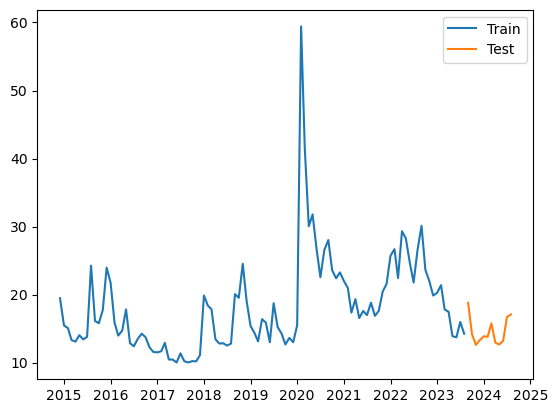

In [8]:
# Plot test and train data 
plt.plot(y_train_full, label='Train')
plt.plot(y_test_full, label='Test')
plt.legend()
plt.show()


Selected Features by RFE: ['NASDAQ Volume', 'RUSSELL2000 Volume', 'FTSE Volume', 'NIKKEI High', 'VIX', 'DJI High Minus Low', 'NASDAQ High Minus Low', 'FTSE High Minus Low', 'RUSSELL2000 High Minus Low', 'VIX lagged 2']


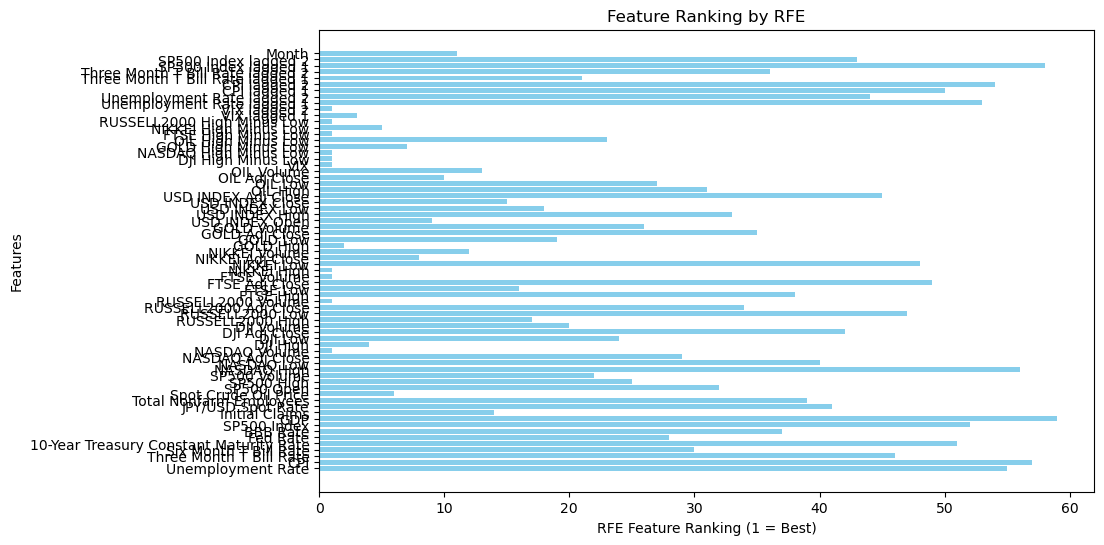

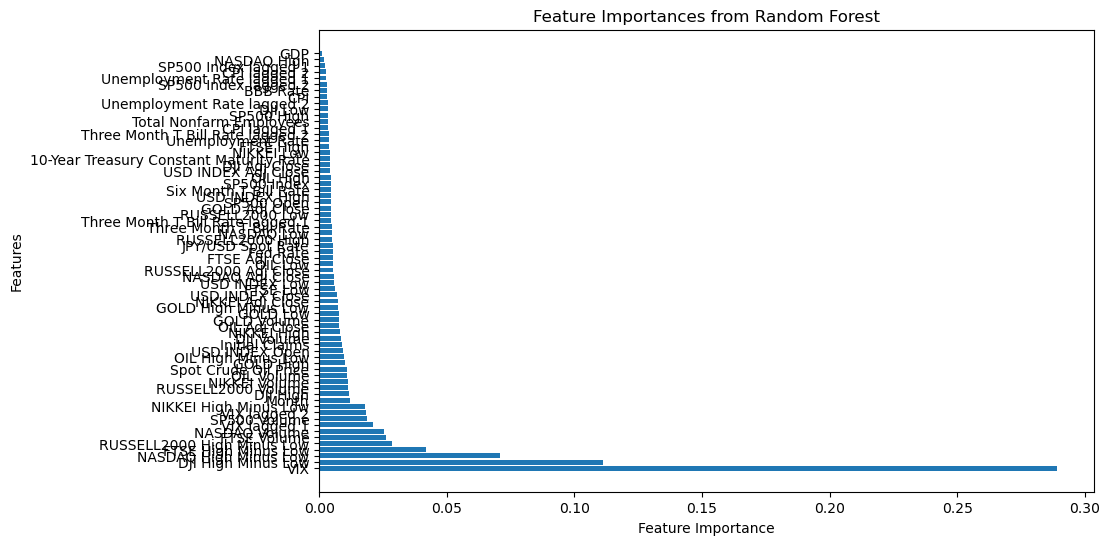

In [9]:
# Determine best features to use to train the model
# Set up a Random Forest Regressor for feature selection
rf = RandomForestRegressor(n_estimators=100, criterion="absolute_error", random_state=42)

# Initialize Recursive Feature Elimination (RFE) with cross-validation
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe.fit(X_train_full, y_train_full)

# RFE Feature Ranking
selected_features = X_train_full.columns[rfe.support_].tolist()
print("Selected Features by RFE:", selected_features)

# Plot RFE feature ranking for all features
ranking = rfe.ranking_
plt.figure(figsize=(10, 6))
plt.barh(X_train_full.columns, ranking, color="skyblue")
plt.xlabel("RFE Feature Ranking (1 = Best)")
plt.ylabel("Features")
plt.title("Feature Ranking by RFE")
plt.show()

# Feature importance from the Random Forest model
rf.fit(X_train_full, y_train_full)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Random Forest")
plt.barh(range(X_train_full.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train_full.shape[1]), X_train_full.columns[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()



In [10]:
X_train_param, X_opt_param, y_train_param, y_opt_param = train_test_split(X_train_full[selected_features], y_train_full, test_size=0.111111, shuffle=False)

In [11]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestRegressor and GridSearchCV
rf = RandomForestRegressor(random_state=42, criterion="absolute_error")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_param, y_train_param)

# Extract the best model and parameters
best_rf = grid_search.best_estimator_
optimized_params = grid_search.best_params_

# Make predictions and calculate performance metrics
y_pred = best_rf.predict(X_opt_param)
rmse = root_mean_squared_error(y_opt_param, y_pred)
mae = mean_absolute_error(y_opt_param, y_pred)
r2 = r2_score(y_opt_param, y_pred)

print("Optimized Parameters:", optimized_params)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Optimized Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 3.0671, MAE: 2.6197, R²: 0.5505


/Users/ThadCreech/opt/anaconda3/envs/summerPython2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [12]:
X = X_train_full[selected_features]
y = y_train_full

In [13]:
rf_model = RandomForestRegressor(n_estimators=optimized_params['n_estimators'], bootstrap=optimized_params['bootstrap'], max_depth=optimized_params['max_depth'], min_samples_split=optimized_params['min_samples_split'], min_samples_leaf=optimized_params['min_samples_leaf'], criterion="absolute_error", random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=4, random_state=42)

In [14]:
y_pred = rf_model.predict(X_test_full[selected_features])
# Calculate RMSE
rmse = root_mean_squared_error(y_test_full, y_pred)
# Calculate MAPE
mape = np.mean(np.abs((y_test_full - y_pred) / y_test_full)) * 100
# Calculate R²
r2 = r2_score(y_test_full, y_pred)
# Calculate Directional Accuracy
directional_accuracy = directionality_score(y_test_full, y_pred)

print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}%")

RMSE: 3.4159, MAPE: 21.1671%, R²: -2.1114, Directional Accuracy: 18.1818%


In [15]:
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [16]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

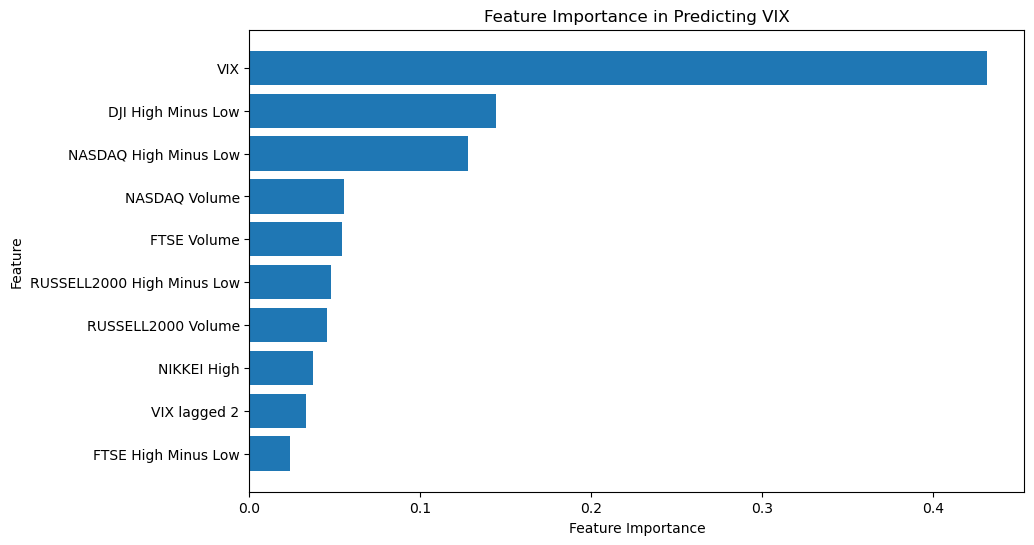

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting VIX')
plt.gca().invert_yaxis()
plt.show()

In [18]:
# Add dates back to predictions
y_pred_df = pd.DataFrame(y_pred, index=X_test_full.index, columns=['Next Month VIX Prediction'])
y_test_df = pd.DataFrame(y_test_full, index=X_test_full.index, columns=['Next Month VIX'])

In [19]:
y_test_full

Date
2023-09-01    18.775
2023-10-01    14.165
2023-11-01    12.595
2023-12-01    13.280
2024-01-01    13.850
2024-02-01    13.785
2024-03-01    15.745
2024-04-01    12.920
2024-05-01    12.645
2024-06-01    13.190
2024-07-01    16.690
2024-08-01    17.070
Name: Next Month VIX, dtype: float64

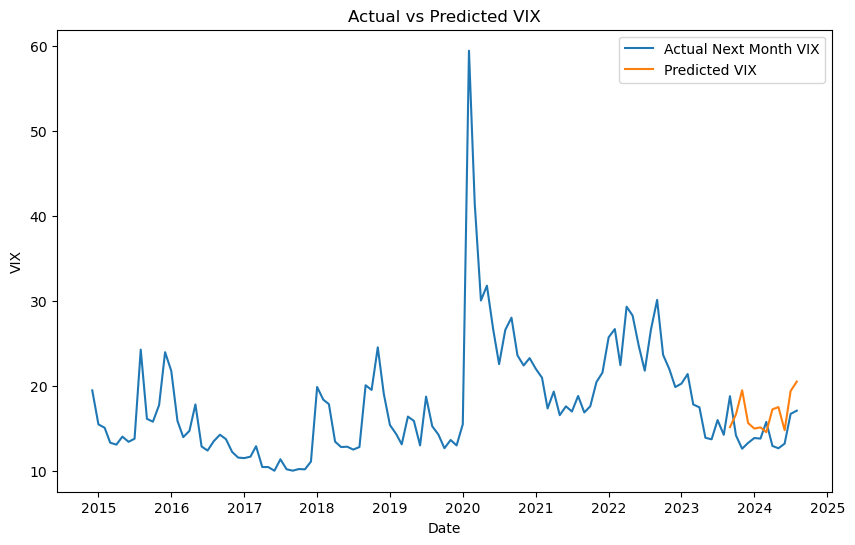

In [20]:
# Plot the actual VIX for the entire time series and the predicted VIX for the test set
plt.figure(figsize=(10, 6))
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.plot(y_entire, label='Actual Next Month VIX')
plt.plot(y_pred_df.index, y_pred_df['Next Month VIX Prediction'], label='Predicted VIX')
plt.legend()
plt.show()



In [21]:
# Combine Data Frame of Predictions and Actual VIX
combined = pd.concat([y_test_df, y_pred_df], axis=1)
combined

,Next Month VIX,Next Month VIX Prediction
Date,,
2023-09-01,18.775,15.133775
2023-10-01,14.165,16.624500
2023-11-01,12.595,19.476475
2023-12-01,13.280,15.611725
2024-01-01,13.850,14.963450
2024-02-01,13.785,15.105625
2024-03-01,15.745,14.543925
2024-04-01,12.920,17.225125
2024-05-01,12.645,17.493875


In [22]:
# Predict VIX for the entire time series
y_pred_full = rf_model.predict(data_clean[selected_features])
y_pred_full_df = pd.DataFrame(y_pred_full, index=data_clean.index, columns=['Next Month VIX Prediction'])

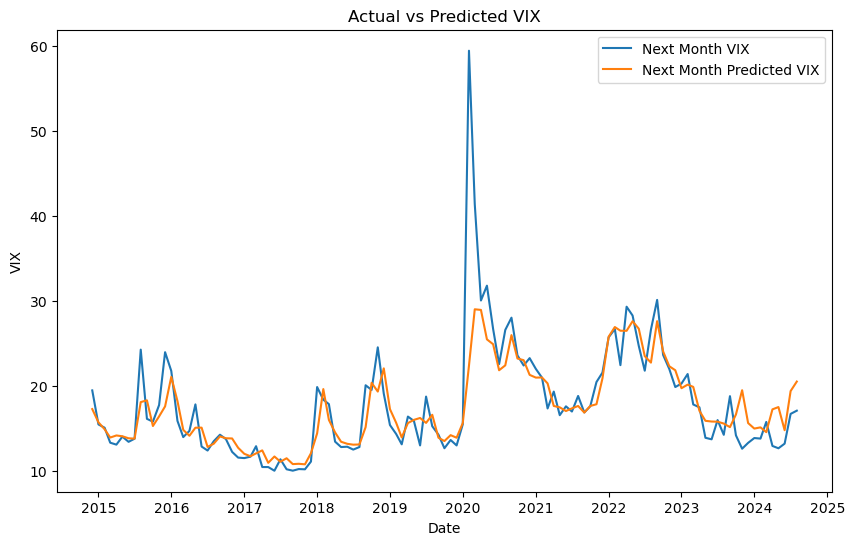

In [23]:
# Plot the actual VIX for the entire time series and the predicted VIX for the entire series
plt.figure(figsize=(10, 6))
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.plot(y_entire, label='Next Month VIX')
plt.plot(y_pred_full_df.index, y_pred_full_df['Next Month VIX Prediction'], label='Next Month Predicted VIX')
plt.legend()
plt.show()


In [24]:
# Calculate RMSE, MAPE, R², and Directional Accuracy for the entire time series
rmse = root_mean_squared_error(y_entire, y_pred_full)
mape = np.mean(np.abs((y_entire - y_pred_full) / y_entire)) * 100
r2 = r2_score(y_entire, y_pred_full)
directional_accuracy = directionality_score(y_entire, y_pred_full)

print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}%")

RMSE: 4.2257, MAPE: 9.8848%, R²: 0.6124, Directional Accuracy: 62.9310%
